In [1]:
import pydot
import numpy as np
from IPython.display import display, Javascript, SVG
from pydrake.examples.manipulation_station import ManipulationStation
from manipulation.scenarios import (
    AddIiwa, AddShape
)
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad
)
from pydrake.all import (
    Adder, Frame,AngleAxis,
    AddMultibodyPlantSceneGraph, BasicVector, DiagramBuilder, MeshcatVisualizerCpp, MeshcatVisualizerParams, Parser, 
    RollPitchYaw, RigidTransform, RevoluteJoint, Sphere, Simulator, InverseDynamicsController, MultibodyPlant, PiecewisePolynomial,
    PiecewiseQuaternionSlerp, TrajectorySource, Quaternion,
    RotationMatrix, Rgba, LeafSystem, Integrator, PassThrough, Demultiplexer, JacobianWrtVariable, Multiplexer, SceneGraph, StateInterpolatorWithDiscreteDerivative
)
import pydrake.all

import pandas as pd

def dataframe(trajectory, times, names):
    assert trajectory.rows() == len(names)
    values = trajectory.vector_values(times)
    data = {'t': times }
    for i in range(len(names)):
        data[names[i]] = values[i,:]
    return pd.DataFrame(data)

import iiwa_rock_climbing.utils

In [46]:
meshcat = StartMeshcat()

In [60]:
# World state
BASE_MASS = 100
INITIAL_JOINT_POSITIONS = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]

APPROACH_VECTOR = [[-0.15, 0, 0.5], [-0.15, 0, 0,]] # Rock frame
CONTACT_POSITION = [-.14,  5.49047152e-17, 1.05864376e-01] # Rock frame
GRIPPER_ORIENTATION = iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,-np.pi/15,0]) #[1, 0, 0, 0]
ROCK_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,0,0]),
                            [0.65, 0, 0.6]])

# Tunable parameters
TIME_STEP = 0.001
PREGRASP_DISTANCE = 0.08 # in meters
POSITION_THRESHOLD = 0.02 # in meters
RELEASE_THRESHOLD = 0.06 # in meters
Z_FORCE = 300 #300


# Cartesian control parameters
CART_KP_ANGULAR = 10
CART_KP_LINEAR = 7
CART_MAX_TRANSLATION_SPEED = 0.3#0.3#0.6 # m/s
CART_MAX_ROTATION_SPEED = 3    # rad/s

# Hybrid control parameters
HYBRID_KP_LINEAR = 0#500
HYBRID_KP_ANGULAR = 0 #200
HYBRID_MAX_TRANSLATION_FORCE = 0 #500
HYBRID_MAX_ROTATION_FORCE = 0#500

In [73]:
# Uncomment for convenience
climber = IIWA_Climber()
climber.reset()

0.7970894837546569


In [74]:
climber.run()

HERE


KeyboardInterrupt: 

In [49]:
def AddIiwaWithHook(plant, collision_model="with_box_collision", mass=BASE_MASS, floating=True): #no_collision
    sdf_path = "iiwa_rock_climbing/models/iiwa_description/iiwa7/" + \
        f"iiwa7_{collision_model}.sdf"

    parser = Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path)
    # Set default positions:
    q0 = INITIAL_JOINT_POSITIONS
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):       
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
            
    gripper = parser.AddModelFromFile("iiwa_rock_climbing/models/hook_convex/hook_convex.sdf", model_name="hook")
        
    # Weld gripper to iiwa
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7"), 
        plant.GetFrameByName("hook_link", model_instance=gripper), 
        RigidTransform(RollPitchYaw(0, -np.pi/2, 0), [-0.05, 0, 0.04]))
        
    # For gripper inline
    # RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.07]))
    
    # Weld iiwa to base 
    base = AddShape(plant, pydrake.geometry.Box(0.2,0.2,0.2), "mobile_base", 
                    mass=mass, mu=1, color=[.5, .5, .9, 1.0])
    plant.WeldFrames(plant.GetFrameByName("mobile_base"), 
                     plant.GetFrameByName("iiwa_link_0"),
                     RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.1]))
    
    # Weld base to world
    if not floating:
        plant.WeldFrames(plant.world_frame(), 
                         plant.GetFrameByName("mobile_base"))

    return iiwa

In [50]:
class StateController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant # Connect this to free-floating plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetFrameByName("hook_link", plant.GetModelInstanceByName("hook"))
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")

        # For computing end-effector position
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.X_WB_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        
        # For computing trajectory (Note: these are hard-coded for now, but could eventually
        # be converted into inputs
        self.rock_pose_measured = np.array(ROCK_POSE) # wrt world
        self.approach_start_cmd = np.array(APPROACH_VECTOR[0]) # wrt rock
        self.approach_end_cmd = np.array(APPROACH_VECTOR[1]) # wrt rock
        self.gripper_orientation_cmd = np.array(GRIPPER_ORIENTATION) # wrt rock
        self.contact_position = np.array(CONTACT_POSITION) # wrt rock
        self.position_threshold = POSITION_THRESHOLD
        self.pregrasp_distance = PREGRASP_DISTANCE
        self.release_threshold = RELEASE_THRESHOLD
        
        # Create drake versions of fixed vectors
        self.X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(self.rock_pose_measured)

        # Declare output ports
        # Cartesian control consists of a specified pre-grasp pose
        self.DeclareVectorOutputPort("cartesian_ctrl", BasicVector(7), 
                                     self.CalcCartCtrlParams)
        # Hybrid control params consist of:         
        # rock_pose_measured (7)
        # approach_start_cmd (3)
        # approach_end_cmd (3)
        # gripper_orientation_cmd (4)
        # TOTAL = 17
        self.DeclareVectorOutputPort("hybrid_ctrl", BasicVector(17), 
                                     self.CalcHybridCtrlParams)
        
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
        
        self.states = ["idle", "init", "pregrasp", "climbing"]
        self.current_state = "init"
        self.pregrasp_pose = None
    
    def UpdatePlant(self, context):
        # Read values from port
        X_WB_vec = self.X_WB_port.Eval(context)
        q_vec = self.q_port.Eval(context)

        # Create drake versions of pose vectors
        X_WB = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WB_vec)

        # Update plant with inputs from world
        self._plant.SetFreeBodyPose(self._plant_context, self._base, X_WB)
        self._plant.SetPositions(self._plant_context, self._iiwa, q_vec)
        return q_vec, X_WB_vec, X_WB
    
    def ComputePregraspPose(self):
        """ Compute pre-grasp position wrt rock - point along vector between 
        approach_start_cmd and contact_position, but offset along vector by 
        position_threshold
        
        Ouputs pose in world frame as a vector
        """        
        # Notation convenience
        p_RGstart = self.approach_start_cmd
        p_RGgrasp = self.contact_position
        
        GstartGgrasp_vec = p_RGgrasp - p_RGstart
        GstartGgrasp_norm = np.linalg.norm(GstartGgrasp_vec)
        
        # Compute magnitude parameter along vector
        t = (GstartGgrasp_norm - self.pregrasp_distance) / GstartGgrasp_norm
        print(t)
        p_RGpre = p_RGstart + t*GstartGgrasp_vec
        
        # Create pose        
        X_RGpre = iiwa_rock_climbing.utils.CreatePoseFromVectors(self.gripper_orientation_cmd, 
                                                                 p_RGpre)
        
        # Convert to world coords
        X_WGpre = self.X_WR @ X_RGpre
        
        # Visualize frames
        # iiwa_rock_climbing.utils.visualize_frame(meshcat, "rock", self.X_WR)
        # iiwa_rock_climbing.utils.visualize_frame(meshcat, "pregrasp", X_WGpre)
        # iiwa_rock_climbing.utils.visualize_point(meshcat, "start", self.X_WR@p_RGstart)
        # iiwa_rock_climbing.utils.visualize_point(meshcat, "grasp", self.X_WR@p_RGgrasp)
        
        return iiwa_rock_climbing.utils.CreateVectorFromPose(X_WGpre)
        
    def CalcCartCtrlParams(self, context, output):
        cmd = np.zeros(7)
        # Update state
        q_vec, X_WB_vec, X_WB = self.UpdatePlant(context)
        
        # Update visualization
        # self.VisualizeCOM()
        
        # Pregrasp pose only needs to be computed on first iteration
        if self.current_state=="init": 
            # Step 1: Compute pre-grasp pose
            self.pregrasp_pose = self.ComputePregraspPose()
            
            # Step 2: Update state
            self.current_state = "pregrasp"
            
        if self.current_state=="pregrasp" or self.current_state=="climbing":########NOTE: should not run in climbing mode, but empirically works well
            # Step 1: Check if we're ready to move onto next state
            # TODO: add orientation-based threshold 
            X_WG = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)
            position_error = np.linalg.norm(self.pregrasp_pose[4:] - X_WG.translation())
            if position_error < self.position_threshold:
                self.current_state="climbing"

            # Step 2: Output Command
            cmd = self.pregrasp_pose
                      
        output.SetFromVector(cmd) 
        
    def CalcHybridCtrlParams(self, context, output):
        cmd = np.zeros(17)
        
        if self.current_state=="climbing":
            # Step 1: Update state
            q_vec, X_WB_vec, X_WB = self.UpdatePlant(context)
            
            # Step 2: Check if we're no longer in contact 
            X_WG = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)
            position_error = np.linalg.norm(self.pregrasp_pose[4:] - X_WG.translation())
            if position_error > self.release_threshold:
                print("HERE")
                self.current_state="idle"
            
            # Step 2: Output Command
            cmd = np.concatenate([self.rock_pose_measured,
                                  self.approach_start_cmd,
                                  self.approach_end_cmd,
                                  self.gripper_orientation_cmd])
        
        output.SetFromVector(cmd)
        
    def Reset(self):
        self.current_state = "init"
        self.pregrasp_pose = None
        
    def VisualizeCOM(self):
        p_WCom = self._plant.CalcCenterOfMassPositionInWorld(self._plant_context)
        iiwa_rock_climbing.utils.visualize_point(meshcat, "com", p_WCom, radius=0.06)

In [51]:
class ServoController(LeafSystem):
    """Closed-loop controller for end effector positioning. Based on current 
    cartesian offset, compute angular and linear velocity command"""
    
    # TODO: Add damping
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        # self._G = plant.GetFrameByName("hook_link")
        self._G = plant.GetFrameByName("hook_link", plant.GetModelInstanceByName("hook"))
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")

        self.X_WGdes_port = self.DeclareVectorInputPort("cartesian_pose_desired", BasicVector(7))
        self.X_WBest_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
            
        self.DeclareVectorOutputPort("cartesian_velocity_cmd", BasicVector(6), self.CalcVelOutput) # wx, wy, wz, tx, ty, tz
        
        self.kp_angular = CART_KP_ANGULAR
        self.kp_linear = CART_KP_LINEAR
        
        self.max_translation_speed = CART_MAX_TRANSLATION_SPEED # m/s
        self.max_rotation_speed = CART_MAX_ROTATION_SPEED       # rad/s

    def CalcVelOutput(self, context, output):
        X_WGdes_vec = self.X_WGdes_port.Eval(context)
        X_WBest_vec = self.X_WBest_port.Eval(context)
        q_vec = self.q_port.Eval(context)
        
        # By default, set output to 0. Only set non-zero output when 
        # input vectors are non-zero
        if np.linalg.norm(X_WGdes_vec) == 0:
            output.SetFromVector(np.zeros(6))
        else:
            # Create drake versions of pose vectors
            X_WGdes = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WGdes_vec)
            X_WBest = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WBest_vec)

            # Update plant with inputs from world
            self._plant.SetFreeBodyPose(self._plant_context, self._base, X_WBest)
            self._plant.SetPositions(self._plant_context, self._iiwa, q_vec)

            # Compute relative transform between gripper and base
            X_BGest = self._plant.CalcRelativeTransform(self._plant_context, self._base.body_frame(), self._G)

            # Transform desired position to base frame
            X_BGdes = X_WBest.inverse() @ X_WGdes

            # Convert to vectors
            q_est, p_est = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGest)
            q_des, p_des = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGdes)

            # Compute velocity command
            v = self.kp_linear*(p_des-p_est)

            # Set velocity limits
            v[v>self.max_translation_speed] = self.max_translation_speed
            v[v<-self.max_translation_speed] = -self.max_translation_speed

            # Compute angular veloctiy command
            q_est = iiwa_rock_climbing.utils.VectorToQuaternion(q_est)
            q_des = iiwa_rock_climbing.utils.VectorToQuaternion(q_des)
            theta = iiwa_rock_climbing.utils.ComputeAngleBetweenQuaternions(q_des, q_est)

            # TODO: write remap function
            # t = self.kp_angular * theta
            t = 1
            if theta != 0:
                t = self.max_rotation_speed / theta
            if t > 1: t=1
            if t < 0: t=0

            q_step = Quaternion(q_est).slerp(t, q_des)

            # r_delta = np.array([q_step.x() - q_est.x(),
            #                     q_step.y() - q_est.y(),
            #                     q_step.z() - q_est.z()])
            
            # r_delta = np.array([quat_start.x() - quat_est.x(),
            #                     quat_start.y() - quat_est.y(),
            #                     quat_start.z() - quat_est.z()])
            q = q_des @ q_est.inverse()
            r_delta = np.array([q.x(), q.y(), q.z()])
            # r_delta = np.array([0,0,0])
            w = self.kp_angular*r_delta

            # Set angular velocity limits
            w[w>self.max_rotation_speed] = self.max_rotation_speed
            w[w<-self.max_rotation_speed] = -self.max_rotation_speed

            # Set output
            output.SetFromVector(np.concatenate((w, v)))
        

In [52]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._base = plant.GetBodyByName("mobile_base")
        # self._G = plant.GetFrameByName("hook_link")
        self._G = plant.GetFrameByName("hook_link", plant.GetModelInstanceByName("hook"))
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("cartesian_velocity_desired", BasicVector(6))
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        
        self.DeclareVectorOutputPort("iiwa_vel_cmd", BasicVector(7), 
                                     self.CalcVelOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
        
    def CalcVelOutput(self, context, output):       
        V_G = self.V_G_port.Eval(context) #[wx, wy, wz, vx, vy, vz]
        q = self.q_port.Eval(context)
        
        # Update plant used for computations
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        
        # Jacobian shape is (6 rows, 13 cols) 
        # rows = spatial velocities (roll, pitch, yaw, x, y, z)
        # cols = derivatives with respect to generalized velocities
        # iiwa_start = 6
        # iiwa_end = 12
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)
        

In [53]:
class PassthroughPrinter(LeafSystem):
    """ Debugger - put this in-between two blocks to print out port data """
    def __init__(self, dim=7):
        LeafSystem.__init__(self)
        self.in_port = self.DeclareVectorInputPort("input_port", BasicVector(dim))
        self.out_port = self.DeclareVectorOutputPort("output_port", BasicVector(dim), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        in_data = self.in_port.Eval(context)
        print("PORT_DEBUGGER:", in_data)
        output.SetFromVector(in_data)        

In [54]:
class TorqueController(LeafSystem):
    """ 
    Torque controller - all translation and orientation axes are position 
    controlled except for Z axis, which is controlled by force 
    
    Outputs torque commands wrt base
    """
    def __init__(self, plant, force_z=Z_FORCE):
        LeafSystem.__init__(self)
        self._plant = plant 
        self._plant_context = plant.CreateDefaultContext() 
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        # self._G = plant.GetFrameByName("hook_link")
        self._G = plant.GetFrameByName("hook_link", plant.GetModelInstanceByName("hook"))
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")
        
        self._fz_des = force_z
        self.kp_linear = HYBRID_KP_LINEAR
        self.kp_angular = HYBRID_KP_ANGULAR
        self.max_translation_force = HYBRID_MAX_TRANSLATION_FORCE
        self.max_rotation_force = HYBRID_MAX_ROTATION_FORCE

        # Measurements
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.q_dot_port = self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(7))
        self.rock_pose_port = self.DeclareVectorInputPort("rock_pose_measured", BasicVector(7))
        self.base_pose_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        
        # Commands
        self.app_start_port = self.DeclareVectorInputPort("approach_start_cmd", BasicVector(3))
        self.app_end_port = self.DeclareVectorInputPort("approach_end_cmd", BasicVector(3))
        self.grip_quat_port = self.DeclareVectorInputPort("gripper_orientation_cmd", BasicVector(4))

        # Outputs
        self.DeclareVectorOutputPort("iiwa_torque_cmd", BasicVector(7),
                                     self.CalcTorqueOutput)

    def CalcTorqueOutput(self, context, output):    
        # Read inputs 
        q_now         = self.q_port.Eval(context) # iiwa_position_measured
        v_now         = self.q_dot_port.Eval(context) # iiwa_velocity_measured
        X_WR_vec      = self.rock_pose_port.Eval(context) # rock_pose_measured, wrt world
        X_WB_vec      = self.base_pose_port.Eval(context) # base_pose_measured, wrt world
        p_RGstart_vec = self.app_start_port.Eval(context) # approach_start_cmd, wrt rock
        p_RGend_vec   = self.app_end_port.Eval(context) # approach_end_cmd, wrt rock
        R_RG_vec      = self.grip_quat_port.Eval(context) # gripper_orientation_cmd, wrt rock
        
        # Check if inputs are valid - if all zero, then we should just output a 0 torque command to all joints
        if sum(abs(R_RG_vec)) + sum(abs(X_WR_vec)) + sum(abs(p_RGstart_vec)) + sum(abs(p_RGend_vec)) == 0:
            output.SetFromVector(np.zeros(7))
            return
     
        # Update plant with inputs from world
        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
        
        # Compute translational torque -------------------------------------------------------------
        # Compute estimated gripper pose wrt base
        X_BGest = self._plant.CalcRelativeTransform(self._plant_context, self._base.body_frame(), self._G)
        
        # Compute gripper control frame wrt base
        X_RGstart =  iiwa_rock_climbing.utils.CreatePoseFromVectors(R_RG_vec, p_RGstart_vec)
        X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WR_vec)
        X_WGstart = X_WR @ X_RGstart
        X_WB = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WB_vec)
        X_BGstart = X_WB.inverse() @ X_WGstart
                
        # Convert to vectors
        q_est, p_est = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGest)
        q_start, p_start = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGstart)
              
        # Compute spatial forces wrt base
        f_B = self.kp_linear*(p_start-p_est)
                
        # Set force limits
        f_B[f_B>self.max_translation_force] = self.max_translation_force
        f_B[f_B<-self.max_translation_force] = -self.max_translation_force

        # Transform forces to gripper start frame
        f_G = X_BGstart.inverse().rotation() @ f_B
        
        # Set z force wrt gripper start
        f_G[2] = -self._fz_des
        
        # Transform forces back to base frame
        f_B = X_BGstart.rotation() @ f_G
        
        # Compute rotational force --------------------------------------------------------------
        quat_est = iiwa_rock_climbing.utils.VectorToQuaternion(q_est)
        quat_start = iiwa_rock_climbing.utils.VectorToQuaternion(q_start)
        theta = iiwa_rock_climbing.utils.ComputeAngleBetweenQuaternions(quat_start, quat_est)

        # TODO: write remap function
        # t = self.kp_angular * theta
        t = 1
        # if theta != 0:
        #     t = self.max_rotation_force / theta
        # if t > 1: t=1
        # if t < 0: t=0
#         q_step = Quaternion(q_est).slerp(t, q_des)

        # r_delta = np.array([quat_start.x() - quat_est.x(),
        #                     quat_start.y() - quat_est.y(),
        #                     quat_start.z() - quat_est.z()])
        q = quat_start @ quat_est.inverse()
        r_delta = np.array([q.x(), q.y(), q.z()])
        # r_delta = np.array([0,0,0])
    
        # Compute rotational forces wrt base
        t_B = self.kp_angular*r_delta

        # Set angular force limits
        t_B[t_B>self.max_rotation_force] = self.max_rotation_force
        t_B[t_B<-self.max_rotation_force] = -self.max_rotation_force
        
        # Output ---------------------------------------------------------------------------------
        F = np.concatenate([t_B, f_B]) #####NOTE: works well with f_G, should be f_B
              
        # Compute jacobian wrt base frame
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._base.body_frame(), self._base.body_frame())
     
        # Only select relevant terms. We end up with J_G of shape (6,7). 
        # Rows correspond to (roll, pitch, yaw x, y, z).
        # Columns correspond to (q0, q1, q2, q3, q4, q5, q6) (qdot)
        # Jacobian dimensions: 6 x 14 
        J_G = J_G[:,7:14]

        # Convert back from cartesian gripper to joint coordinates
        tau_cmd = J_G.T.dot(F)
        # print(tau_cmd)
        output.SetFromVector(tau_cmd)
        

In [55]:
class IIWA_Climber():
    def __init__(self, traj=None):
        self.simulator = None
        
        builder = DiagramBuilder()
        
        # Plant setup ####################################################
        self.plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=TIME_STEP)
        parser = Parser(self.plant)
        
        visualizer = MeshcatVisualizerCpp.AddToBuilder(
            builder, 
            scene_graph, 
            meshcat,
            MeshcatVisualizerParams(delete_prefix_initialization_event=False))
        
        # World setup ----------------------
        rock = parser.AddModelFromFile("iiwa_rock_climbing/models/bowl_convex/bowl_convex.sdf", model_name="bowl")
        
        # Weld rock to world
        X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(ROCK_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("bowl_link"),
            RigidTransform(X_WR))             
        
        
        TEMP_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([np.pi/2,0,0]),
                            [1,1,0]])
        bowl_nonconvex = parser.AddModelFromFile("iiwa_rock_climbing/models/bowl_convex/bowl.sdf", model_name="bowl_nonconvex")
        X_temp = iiwa_rock_climbing.utils.CreatePoseFromVector(TEMP_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("bowl_link", model_instance=bowl_nonconvex),
            RigidTransform(X_temp))             
        
        TEMP_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,0,0]),
                    [1,1.4,0]])
        bowl_convex = parser.AddModelFromFile("iiwa_rock_climbing/models/bowl_convex/bowl_convex.sdf", model_name="bowl_convex")
        X_temp = iiwa_rock_climbing.utils.CreatePoseFromVector(TEMP_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("bowl_link", model_instance=bowl_convex),
            RigidTransform(X_temp))             
        
        TEMP_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,-np.pi/2,np.pi/2]),
                    [0.8,1.4,0]])
        hook_convex = parser.AddModelFromFile("iiwa_rock_climbing/models/hook_convex/hook_convex.sdf", model_name="hook_convex")
        X_temp = iiwa_rock_climbing.utils.CreatePoseFromVector(TEMP_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("hook_link", model_instance=hook_convex),
            RigidTransform(X_temp))             
        
        TEMP_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,-np.pi/2,np.pi]),
                    [0.8,1,0]])
        hook_nonconvex = parser.AddModelFromFile("iiwa_rock_climbing/models/hook_convex/hook.sdf", model_name="hook_nonconvex")
        X_temp = iiwa_rock_climbing.utils.CreatePoseFromVector(TEMP_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("hook_link", model_instance=hook_nonconvex),
            RigidTransform(X_temp))             
        
        
        
        
        # Iiwa setup ------------------------
        self.iiwa = AddIiwaWithHook(self.plant)                
        self.plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.plant.Finalize()

        #####################################################################
        
        # Export the iiwa "state" outputs.
        num_iiwa_positions = self.plant.num_positions(self.iiwa)
        demux = builder.AddSystem(Demultiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.plant.get_state_output_port(self.iiwa), demux.get_input_port())    
        iiwa_position_port = demux.get_output_port(0)
        builder.ExportOutput(iiwa_position_port, "iiwa_position_measured")
        iiwa_velocity_port = demux.get_output_port(1)
        builder.ExportOutput(iiwa_velocity_port, "iiwa_velocity_estimated")
        iiwa_state_port = self.plant.get_state_output_port(self.iiwa)
        builder.ExportOutput(iiwa_state_port, "iiwa_state_estimated")     
        
        # Export base "state" outputs
        demux_base = builder.AddSystem(Demultiplexer([7, 6])) # 7 for position, 6 for velocity state (free floating base)
        builder.Connect(self.plant.GetOutputPort('mobile_base_continuous_state'),
                        demux_base.get_input_port())    
        base_position_port = demux_base.get_output_port(0)
        base_velocity_port = demux_base.get_output_port(1)
                
        # --------------------------------------------------------------------------------
        # Set up plant with fixed base for controller computations
        # (inverse dynamics requires fully acutated plant, and jacobians seem
        # to work best with fixed base)
        self.controller_plant = MultibodyPlant(time_step=TIME_STEP)
        self.controller_plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.controller_iiwa = AddIiwaWithHook(self.controller_plant, floating=False)
        controller_parser = Parser(self.controller_plant)           
        self.controller_plant.Finalize()    
        
        # Add iiwa inverse dyanmics controller -------------------------------------------
        self.inv_dyn_controller = builder.AddSystem(
            InverseDynamicsController(
                self.controller_plant,
                kp=[100]*num_iiwa_positions,
                ki=[1]*num_iiwa_positions,
                kd=[20]*num_iiwa_positions,
                has_reference_acceleration=False))
        self.inv_dyn_controller.set_name("inv_dyn_controller");
        
        builder.Connect(self.plant.get_state_output_port(self.iiwa),
                        self.inv_dyn_controller.get_input_port_estimated_state())    

        # Add discrete derivative to command velocities.
        desired_state_from_position = builder.AddSystem(
            StateInterpolatorWithDiscreteDerivative(
                num_iiwa_positions, TIME_STEP, suppress_initial_transient=True))
        desired_state_from_position.set_name("desired_state_from_position")
        builder.Connect(desired_state_from_position.get_output_port(),      
                        self.inv_dyn_controller.get_input_port_desired_state())
        
        # Pseudo-inverse controller -----------------------------------------------------
        self.pinv_controller = builder.AddSystem(PseudoInverseController(self.controller_plant))
        
        builder.Connect(iiwa_position_port, 
                self.pinv_controller.GetInputPort('iiwa_position_measured'))
        
        # Add integrator to output to convert from joint velocities to positions 
        self.integrator = builder.AddSystem(Integrator(7))
        builder.Connect(self.pinv_controller.GetOutputPort("iiwa_vel_cmd"), 
                        self.integrator.get_input_port())
        builder.Connect(self.integrator.get_output_port(), 
                        desired_state_from_position.get_input_port())    

            
        # Closed-loop control for pseudoinverse ----------------------------------------
        self.servo_controller = builder.AddSystem(ServoController(self.plant))
                
        builder.Connect(base_position_port, 
                        self.servo_controller.GetInputPort('base_pose_measured'))
        builder.Connect(iiwa_position_port, 
                        self.servo_controller.GetInputPort('iiwa_position_measured'))
        builder.Connect(self.servo_controller.GetOutputPort('cartesian_velocity_cmd'), 
                        self.pinv_controller.GetInputPort('cartesian_velocity_desired'))

        # Feed-forward torque ------------------------------------------------------------
        torque_adder = builder.AddSystem(Adder(2, num_iiwa_positions))
        builder.Connect(self.inv_dyn_controller.get_output_port_control(),
                        torque_adder.get_input_port(0))
        builder.Connect(torque_adder.get_output_port(),
                        self.plant.get_actuation_input_port(self.iiwa))

        # Add torque controller ---------------------------------------------------
        self.torque_controller = builder.AddSystem(TorqueController(self.plant))
        
        builder.Connect(iiwa_position_port, 
                        self.torque_controller.GetInputPort('iiwa_position_measured'))
        builder.Connect(iiwa_velocity_port,
                        self.torque_controller.GetInputPort('iiwa_velocity_measured'))
        builder.Connect(base_position_port, 
                        self.torque_controller.GetInputPort('base_pose_measured'))
        builder.Connect(self.torque_controller.GetOutputPort('iiwa_torque_cmd'),
                        torque_adder.get_input_port(1))
        
        mux = builder.AddSystem(Multiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.integrator.get_output_port(), mux.get_input_port(0))  
        builder.Connect(self.pinv_controller.GetOutputPort("iiwa_vel_cmd"), mux.get_input_port(1))     
                
        # State Controller ---------------------------------------------------------------
        self.smach = builder.AddSystem(StateController(self.plant))
        
        builder.Connect(iiwa_position_port, 
                        self.smach.GetInputPort('iiwa_position_measured'))
        builder.Connect(base_position_port, 
                        self.smach.GetInputPort('base_pose_measured'))

        # Connect to cartesian controller
        builder.Connect(self.smach.GetOutputPort('cartesian_ctrl'), 
                        self.servo_controller.GetInputPort('cartesian_pose_desired'))
                
        # Break out hybrid control parameters
        demux_hybrid = builder.AddSystem(Demultiplexer([7,   # rock_pose_measured (7)
                                                        3,   # approach_start_cmd (3)
                                                        3,   # approach_end_cmd (3)
                                                        4])) # gripper_orientation_cmd (4)
                                                                
        builder.Connect(self.smach.GetOutputPort('hybrid_ctrl'), 
                        demux_hybrid.get_input_port())
        rock_pose_port        = demux_hybrid.get_output_port(0)
        app_start_port        = demux_hybrid.get_output_port(1)
        app_end_port          = demux_hybrid.get_output_port(2)
        grip_orientation_port = demux_hybrid.get_output_port(3)
        builder.Connect(rock_pose_port,
                        self.torque_controller.GetInputPort('rock_pose_measured'))
        builder.Connect(app_start_port,
                        self.torque_controller.GetInputPort('approach_start_cmd'))
        builder.Connect(app_end_port,
                        self.torque_controller.GetInputPort('approach_end_cmd'))
        builder.Connect(grip_orientation_port,
                        self.torque_controller.GetInputPort('gripper_orientation_cmd'))
          
        # Build ---------------------------------------------------------------------------
        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName("hook_link", self.plant.GetModelInstanceByName("hook"))
        self.world_frame = self.plant.world_frame()
               
        context = self.CreateDefaultContext()
        self.diagram.Publish(context)
               
    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)
        self.smach.Reset()
        return context       
        
    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG
    
    def reset(self):
        context = self.CreateDefaultContext()
        self.simulator = Simulator(self.diagram, context)
        self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(INITIAL_JOINT_POSITIONS)

        self.simulator.set_target_realtime_rate(0.25)
        self.simulator.AdvanceTo(0.01)
        self.simulator.AdvanceTo(0.02)
        
    def run(self):
        self.simulator.AdvanceTo(10.0)

In [56]:
climber = IIWA_Climber()

In [57]:
# To visualize initial frame
# X_WGstart = climber.get_X_WG()
# climber.visualize_frame('gripper_current', X_WGstart)

In [58]:
climber.reset()

0.7970894837546569


In [59]:
climber.run()

KeyboardInterrupt: 

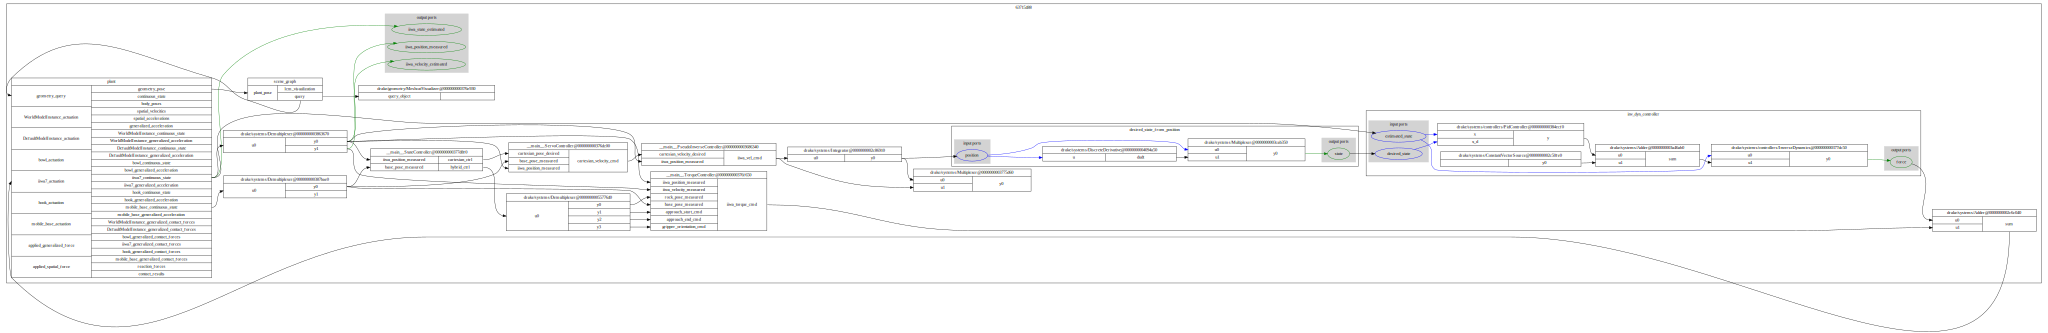

In [12]:
display(SVG(pydot.graph_from_dot_data(climber.diagram.GetGraphvizString())[0].create_svg()))

In [ ]:
# TODO: Add closed-loop controller for position in fromt of pseudo inverse controller
# take in desired position and current global positionas input, 
# NOTE: this version of the notebook shows the error in the pseudoinversecontroller - the math isn't "correct" enough to do this open-loop with a light base
# I think the pseudoinverse controller still is sending the same old joint commands, but because it's floating the inverse dynamics behaves differently?

"""
Roadmap:
- implement closed loop controller - get it to move to a specific pose
- create dummy stand-in for ethan's code - this outputs approach vector and grasp position
- modify state machine. Take in approach vector and grasp position. Compute pregrasp location, switch between states. 
    Output torque_ctl_inputs (approach start, approach end, gripper orientation)
    Output pose_ctl_inputs (cartesian pose command)
- modify torque controller - if all of it's inputs are 0, output 0 torque
- modify pseudoinverse controller - if all it's inputs are 0, output 0 velocity
- add multiplexer in-between state machine and torque ctrl
- finish implementation of torque controller
















Current status: I think the torque controller might be working, but to test it I need to set the 
state controller properly - Next steps:
- add a multiplexer in between state machine and torque ctrl
- visualize torque ctrl frames
- modify state controller to set poses properly
- end-to-end test

- TODO: can increase torque limits, tune parameters, add orientation control to torque controller
- TODO: add stop behavior


New bugs
- wasn't actually using a pre-grasp offset
"""